# Dataset preparing 

In [294]:
'''
Load libs
'''
import torch
import torchvision as tv
import torch.nn.functional as F
import torchvision.transforms as transforms
from torch.utils.data import Dataset, DataLoader

from skimage import io, transform
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np

plt.style.use('ggplot')
np.random.seed(42)

In [295]:
'''
Define data folders 
'''
imgs_dir = './ISIC/images'
mask_dir = './ISIC/masks'
info_filename = './ISIC/imagedata.csv'

In [296]:
'''
Load metadata
'''
info = pd.read_csv(info_filename)
info.tail()

,isic_id,age_approx,anatom_site_general,benign_malignant,diagnosis,diagnosis_confirm_type,melanocytic,sex
1995,ISIC_0001995,10.0,NaN,benign,nevus,single image expert consensus,True,female
1996,ISIC_0001996,15.0,NaN,benign,nevus,single image expert consensus,True,female
1997,ISIC_0001997,15.0,NaN,benign,nevus,single image expert consensus,True,female
1998,ISIC_0001998,15.0,NaN,benign,nevus,single image expert consensus,True,female
1999,ISIC_0001999,15.0,NaN,benign,nevus,single image expert consensus,True,female


In [297]:
def show_imgmask(img, mask, ax=None):
    if ax:
        ax.imshow(img)
        ax.imshow(mask, alpha=0.3)
    else:
        plt.imshow(img)
        plt.imshow(mask, alpha=0.3)
        plt.axis('off')
        plt.show()

./ISIC/images/ISIC_0000041.png
./ISIC/masks/ISIC_0000041_mask.png


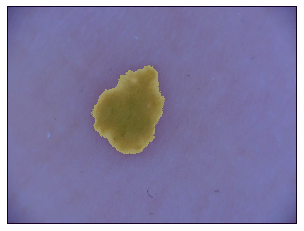

In [298]:
'''
Load one image and one mask
'''
index = 41

# Load image
img_filename = imgs_dir+'/'+info['isic_id'][index]+'.png'
print(img_filename)
img = io.imread(img_filename)

# Load mask
mask_filename = mask_dir+'/'+info['isic_id'][index]+'_mask.png'
print(mask_filename)
mask = io.imread(mask_filename)

show_imgmask(img, mask)

[0. 1.]


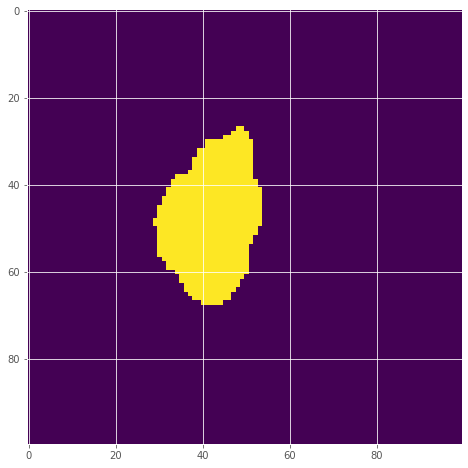

In [299]:
'''
Masks resizing demo (Rescale)
'''
re_mask = transform.resize(mask, (100,100))
re_mask = re_mask.round()
print(np.unique(re_mask))

plt.figure(figsize=(8,8))
plt.imshow(re_mask)
plt.show()

In [300]:
'''
Create a class for our dataset
'''

class ISICDataset(Dataset):
    '''ISIC images masks dataset'''
    
    def __init__(self, imgs_dir, mask_dir, info_filename, transform=None):
        '''
        Args:
            imgs_dir (string): Directory with all images
            mask_dir (string): Directory with all masks
            info_filename (string): Path to the csv file with information about images
            transform (callable, optional): Optional transform to be applied on a sample.
        '''
        self.imgs_dir = imgs_dir
        self.mask_dir = mask_dir
        self.info = pd.read_csv(info_filename)
        self.transform = transform
    
    def __len__(self):
        return info.shape[0]
    
    def __getitem__(self, index):
        if torch.is_tensor(index):
            index = index.tolist()
            
        img_filename = self.imgs_dir+'/'+self.info['isic_id'][index]+'.png'
        mask_filename = self.mask_dir+'/'+self.info['isic_id'][index]+'_mask.png'
        
        image = io.imread(img_filename)
        mask = io.imread(mask_filename)
        
        sample = {'image': image, 'mask': mask}
        
        if self.transform:
            sample = self.transform(sample)
        
        return sample
        

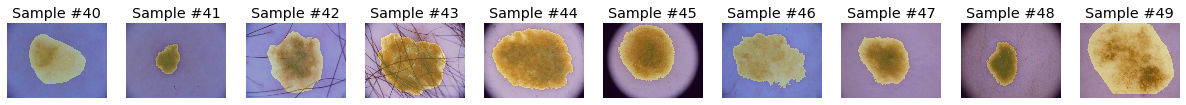

In [301]:
'''
Example of work ISICDataset class
'''
isic_dataset = ISICDataset(imgs_dir, mask_dir, info_filename)

n_images = 10

fig, ax = plt.subplots(1,n_images, figsize=(21,12))
for i in range(n_images):
    index = i + 40
    sample = isic_dataset[index]
    
#     print(i, sample['image'].shape, sample['mask'].shape)

    ax[i].set_title('Sample #{}'.format(index))
    ax[i].axis('off')
    show_imgmask(sample['image'], sample['mask'], ax[i])
plt.show()

In [509]:
'''
Creating transforms
'''
class Rescale(object):
    '''Rescale the image in a sample to a given size.

    Args:
        output_size (tuple or int): Desired output size. If tuple, output is
            matched to output_size. If int, smaller of image edges is matched
            to output_size keeping aspect ratio the same.
    '''

    def __init__(self, output_size):
        assert isinstance(output_size, (int, tuple))
        self.output_size = output_size

    def __call__(self, sample):
        image, mask = sample['image'], sample['mask']
        
        h, w = sample['image'].shape[:2]
        if isinstance(self.output_size, int):
            if h > w:
                new_h, new_w = self.output_size * h / w, self.output_size
            else:
                new_h, new_w = self.output_size, self.output_size * w / h
        else:
            new_h, new_w = self.output_size

        new_h, new_w = int(new_h), int(new_w)

        img = transform.resize(image, (new_h, new_w))
        msk = transform.resize(mask, (new_h, new_w))
        msk = msk.round()
        
        return {'image': img, 'mask': msk}
    
    
class RandomCrop(object):
    """Crop randomly the image in a sample.

    Args:
        output_size (tuple or int): Desired output size. If int, square crop
            is made.
    """

    def __init__(self, output_size):
        assert isinstance(output_size, (int, tuple))
        if isinstance(output_size, int):
            self.output_size = (output_size, output_size)
        else:
            assert len(output_size) == 2
            self.output_size = output_size
    
    def __call__(self, sample):
        image, mask = sample['image'], sample['mask']

        h, w = image.shape[:2]
        new_h, new_w = self.output_size

        top = np.random.randint(0, h - new_h)
        left = np.random.randint(0, w - new_w)

        image = image[top: top + new_h, left: left + new_w]
        mask = mask[top: top + new_h, left: left + new_w]

        return {'image': image, 'mask': mask}
            
class ToTensor(object):
    """Convert ndarrays in sample to Tensors."""

    def __call__(self, sample):
        image, mask = sample['image'], sample['mask']

        # swap color axis because
        # numpy image: H x W x C
        # torch image: C X H X W
        image = image.transpose((2, 0, 1))
        
        return {'image': torch.tensor(image, dtype=torch.float, requires_grad=True).unsqueeze(0),
                'mask': torch.tensor(np.ceil(mask), dtype=torch.long).unsqueeze(0)}

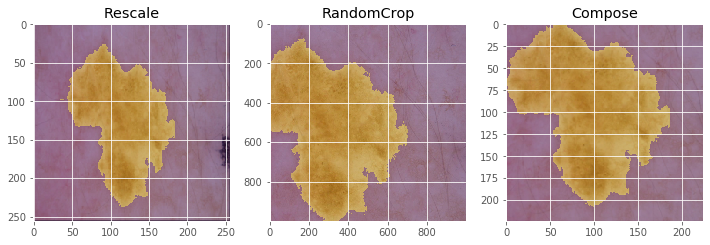

In [510]:
scale = Rescale((256, 256))
crop = RandomCrop(1000)
composed = transforms.Compose([Rescale(256),
                               RandomCrop(224)])
# Apply each of the above transforms on sample.
sample = isic_dataset[21]

fig, ax = plt.subplots(1,3, figsize=(12,6))

for i, tsfrm in enumerate([scale, crop, composed]):
    transformed_sample = tsfrm(sample)

    ax[i].set_title(type(tsfrm).__name__)
    show_imgmask(transformed_sample['image'], transformed_sample['mask'], ax[i])

plt.show()

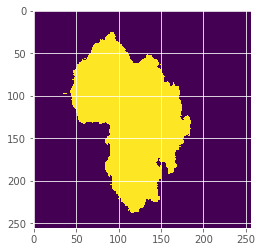

In [511]:
transformed_dataset = ISICDataset(imgs_dir, 
                                  mask_dir, 
                                  info_filename, 
                                  transform=transforms.Compose([
                                      Rescale((256,256)),
                                      ToTensor()
                                  ]))

m = transformed_dataset[21]['mask'].squeeze(0).numpy()

plt.imshow(m)


# U-net
inspired by https://github.com/choosehappy/PytorchDigitalPathology/tree/master/segmentation_epistroma_unet

In [512]:
from unet import UNet # https://github.com/jvanvugt/pytorch-unet

In [565]:
'''
Parameters for U-net
'''
n_classes = 2 # number of calsses in the mask
in_channels = 3 # input channals data (rgb: 3)
padding = True
depth = 5 # depth of net
wf = 2 # number of filters in first layer 2**wf 
up_mode = 'upconv' # upsample of interpolation: 'upconv', 'upsample'
batch_norm = True # batchnorm beween layers

'''
Parameters for training
'''
btch_size = 3
patch_size = 256
n_epoch = 100
edge_weight = 1.1 
# edges tend to be the most poorly segmented given how 
# little area they occupy in the training set, this 
# paramter boosts their values along the lines of the original UNET paper


In [566]:
'''
Prepare device
'''
if(torch.cuda.is_available()):
    print(torch.cuda.get_device_properties(0))
    torch.cuda.set_device(0)
    device = torch.device(f'cuda:{0}')
else:
    device = torch.device(f'cpu')
print(device)

_CudaDeviceProperties(name='GeForce RTX 2080', major=7, minor=5, total_memory=7979MB, multi_processor_count=46)
cuda:0


In [567]:
model = UNet(in_channels, n_classes, depth, wf, padding, batch_norm, up_mode).to(device)
print(f"total params: \t{sum([np.prod(p.size()) for p in model.parameters()])}")

total params: 	122466


In [568]:
optimizer = torch.optim.Adam(model.parameters())
criterion = torch.nn.CrossEntropyLoss()

In [441]:
'''
(DSC) Dice loss
'''
# def dice_loss(pred_mask, true_mask):
#     return (((pred_mask[-1][1] > 0).float() * true_mask[-1]).sum() + 1) / \
#             ( (pred_mask[-1][1] > 0).float().sum() + true_mask[-1].sum()+1)

# print(y_pred.shape)
# print(msk.shape)

# print( (((y_pred[-1][1] > 0).float() * msk[-1]).sum() + 1) / ( (y_pred[-1][1] > 0).float().sum() + msk[-1].sum()+1) )

torch.Size([1, 2, 256, 256])
torch.Size([1, 256, 256])
tensor(0.3161, device='cuda:0')


In [517]:
sample = transformed_dataset[0]
image, mask = sample['image'], sample['mask']

# input = image.unsqueeze(0)

# for i in range(1, 10): # n_train train images
#         sample = transformed_dataset[i]
#         image, mask = sample['image'], sample['mask']
#         input = torch.cat((input, image.unsqueeze(0)))
        
image.shape

torch.Size([1, 3, 256, 256])

In [553]:
'''
Batch training
'''
# make batches
sample = transformed_dataset[0]
image, mask = sample['image'], sample['mask']
imgs = image
msks = mask
for n in range(1, 100):
    sample = transformed_dataset[n]
    image, mask = sample['image'], sample['mask']

    imgs = torch.cat((imgs,image))
    msks = torch.cat((msks,mask))


In [569]:
# [N, 3, H, W] - image
# [N, H, W] - mask with classes (0, 1)
img = imgs.to(device)
msk = msks.to(device)

total_loss = []
n_train = 10
for epoch in range(500):
    total_loss += [0.0]
    
    # forward
    y_pred = model(img)

    # loss
    loss = criterion(y_pred, msk)        
    total_loss[-1] += loss

    # update
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()
    
    if epoch % 10 == 9:
        print('{:4d}. Loss: {:3.5f}'.format(epoch, total_loss[-1]/n_train))
        
print(imgs.shape)

   9. Loss: 0.05715
  19. Loss: 0.04774
  29. Loss: 0.04094
  39. Loss: 0.03692
  49. Loss: 0.03261
  59. Loss: 0.02853
  69. Loss: 0.02479
  79. Loss: 0.02209
  89. Loss: 0.01981
  99. Loss: 0.01754
 109. Loss: 0.01582
 119. Loss: 0.01425
 129. Loss: 0.01281
 139. Loss: 0.01181


KeyboardInterrupt: 

In [518]:
'''
One image training
'''
total_loss = []
n_train = 10
for epoch in range(n_epoch):
    total_loss += [0.0]
    for i in range(n_train): # n_train train images
        sample = transformed_dataset[i]
        image, mask = sample['image'], sample['mask']
        
        # [N, 3, H, W] - image
        # [N, H, W] - mask with classes (0, 1)
        img = image.to(device)
        msk = mask.to(device)
        
        # forward
        y_pred = model(img)
        
        # loss
        loss = criterion(y_pred, msk)        
        total_loss[-1] += loss
        
        # update
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
#         if i % 100 == 99:
#             print('Image: {}, loss:{}'.format(i, loss))
    if epoch % 10 == 9:
        print('{:4d}. Loss: {:3.5f}'.format(epoch, total_loss[-1]/n_train))
    
PATH = './models/unet-500-100.pth'
torch.save(model.state_dict(), PATH)

   9. Loss: 0.35753
  19. Loss: 0.19794
  29. Loss: 0.11412
  39. Loss: 0.13250
  49. Loss: 0.06677
  59. Loss: 0.04554
  69. Loss: 0.03882
  79. Loss: 0.02858
  89. Loss: 0.02457
  99. Loss: 0.02400


In [555]:
# Original dice score (1 - same, 0 - different)
def dice_score(input, target):
    # 0 - same
    # 1 - different
    smooth = 1.

    iflat = input#.view(-1)
    tflat = target#.view(-1)
    intersection = (iflat * tflat).sum()
    
    return ((2. * intersection + smooth) /
              (iflat.sum() + tflat.sum() + smooth))

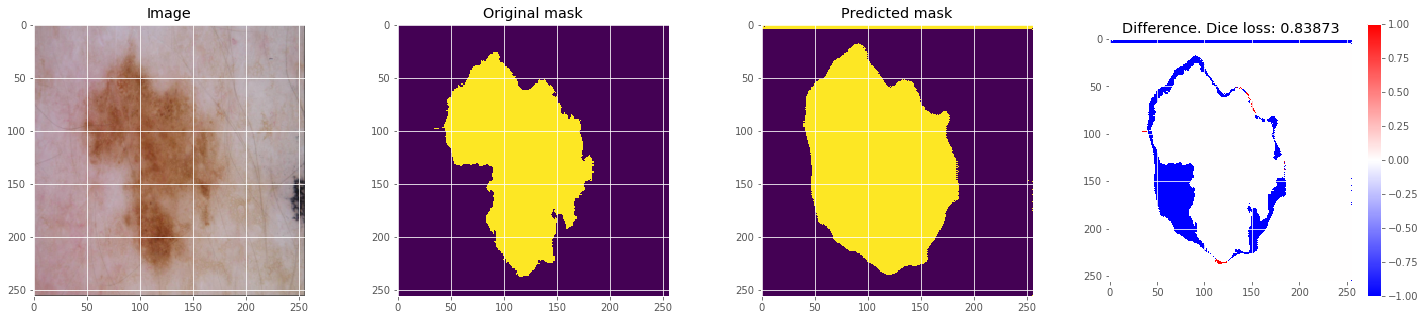

In [564]:
sample = transformed_dataset[21] # 21 41 51 91
image, mask = sample['image'], sample['mask']

in_img = image.detach().squeeze(0).numpy().transpose(1,2,0)
true_mask = mask.numpy().squeeze(0)
in_img.shape
img = image.to(device)
y_pred = model(img)
pred_mask = y_pred.squeeze(0).clone()
pred_mask = pred_mask.detach().cpu().numpy().transpose(1,2,0)
pred_mask = np.round(pred_mask)
pred_mask = np.array(pred_mask > 0, dtype=int)

# plot
fig, ax = plt.subplots(1, 4, figsize=(25,5))

ax[0].imshow(in_img)
ax[0].set_title('Image')
ax[1].imshow(true_mask)
ax[1].set_title('Original mask')
ax[2].imshow(pred_mask[:,:,1])
ax[2].set_title('Predicted mask')
im = ax[3].imshow(true_mask - pred_mask[:,:,1], 'bwr', vmin=-1,vmax=1)
ax[3].set_title('Difference. Dice loss: {:2.5f}'.format(dice_score(pred_mask[:,:,1], true_mask)))
plt.colorbar(im)
plt.show()

In [543]:
'''
TEST
'''
total_dice_score = 0.0
with torch.no_grad():
    for i in range(900, 1000): # 100 test images
        sample = transformed_dataset[i]
        image, mask = sample['image'], sample['mask']

        # [N, 3, H, W] - image
        # [N, H, W] - mask with classes (0, 1)
        img = image.to(device)
        msk = mask.to(device)

        y_pred = model(img)

        # Compute Dice
        true_mask = mask.numpy().squeeze(0)
        pred_mask = y_pred.squeeze(0).clone()
        pred_mask = pred_mask.detach().cpu().numpy().transpose(1,2,0)
        pred_mask = np.round(pred_mask)
        pred_mask = np.array(pred_mask > 0, dtype=int)

        dice = dice_loss(pred_mask[:,:,1], true_mask)
        total_dice_score += dice
        
        if i % 10 == 9:
            print(i, total_dice_score/(i-900))
    
print('Total test dice loss: {:2.6f}'.format(total_dice_score / 100))


909 0.9238567163534724
919 0.8881594521006476
929 0.8972632646011841
939 0.899981212608713
949 0.8860521065057828
959 0.8852049237520061
969 0.8770344881562523
979 0.8820832770790935
989 0.8800014015636625
999 0.8790037343717574
Total test dice loss: 0.870214
